In [1]:
import pandas as pd
import numpy as np
import json
import pickle

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import Dropout

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score

from vickygod import *
%matplotlib inline

Using TensorFlow backend.


# Vicky's Godly Dataset

In [2]:
dataset = pickle.load(open('data/selected_frames.data.p', 'rb'))
law_count = pd.Series.from_csv('data/occurrence.csv')
relation25 = law_count[:25].index
dataset = dataset[dataset.Relation.isin(relation25)]
dataset.head()

,Arg1,Arg2,Relation
0,[],"[七, 年前, ，, 年, 僅, 九, 歲, 及, 八, 歲, 的, 板橋市, 某, 國小,...",殺人罪
1,"[0, ‧, 3, 坪, 喊價, 800萬, 畸零地, 圍籬, 阻, 路, 拆, ！]","[○, ．, 三, 坪, 畸零地, 能, 「, 螞蟻, 吃, 大象, 」, ？, 北市, 議...",道路交通管理處罰條例
2,"[100, cc, 催芽劑奪, 信義, 鄉四, 命]","[信義, 鄉民, 朱明福, ，, 涉嫌, 將, 催芽劑, 摻入, 米酒, ，, 導致, 前,...",殺人罪
3,"[101, 前董座, 林鴻明, 二審, 輕, 判, 1年, 8月]","[前, 台北, 101, 董事長, 林鴻明, ，, 被, 控, 掏空, 股票, 上市, 的,...",證券交易法
4,"[101, 大樓, 前添, 紛爭, 台獨, 大, 旗, 砸傷, 人]","[台北, 101, 大樓, 前, 法輪, 功, 、, 愛國, 同心, 會, 的, 爭端, ，...",傷害罪


In [3]:
laws = dataset.Relation.unique().tolist()

# Parameters

In [4]:
n_classes = len(laws)
n_svd = 300

# Generate Training Data

In [5]:
train_X, train_Y = [], []
for index, frame in dataset.iterrows():
    law_ind = laws.index(frame['Relation'])
    seg_content = ' '.join(frame['Arg2'])
    train_X.append(seg_content)
    train_Y.append(law_ind)

# 1. Make artilcles of same classes into a huge document & Tfidf

In [6]:
train_x, valid_x, train_y, valid_y = train_test_split(train_X, train_Y, test_size=0.25, random_state=42)
huge_doc = {c: '' for c in range(n_classes)}
for x, y in zip(train_x, train_y):
    huge_doc[y] += ' ' + x

# 0~n_classes store huge doc
corpus = [huge_doc[c] for c in range(n_classes)] + valid_x
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(corpus)
train_vec, valid_vec = vectors[:n_classes], vectors[n_classes:]

pred_y = []
for i, y in enumerate(valid_y):
    # Get largest similarity
    pred_y.append(cosine_similarity(train_vec, valid_vec[i]).T[0].argsort()[-1])

print('Acc: %.6f' % accuracy_score(valid_y, pred_y))

Acc: 0.766975


# 2. Tfidf & LSA for each articles

In [7]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(train_X)
svd = TruncatedSVD(n_svd)
normalizer = Normalizer()
lsa = make_pipeline(svd, normalizer)

train_x = lsa.fit_transform(vectors)
train_y = to_categorical(train_Y, n_classes)

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.25, random_state=42)

# A Garbage Model

In [8]:
def get_garbage_model():
    model = Sequential()
    model.add(Dense(n_svd // 2, activation='relu', input_dim=n_svd))
    model.add(Dropout(0.3))
    model.add(Dense(n_svd // 4, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    return model

Max Valid Acc Epoch
            acc      loss      acc      loss
          train     train    valid     valid
epoch                                       
30     0.988169  0.053968  0.79321  0.968649
34     0.992798  0.039363  0.79321  1.022738
39     0.992798  0.037815  0.79321  1.046066


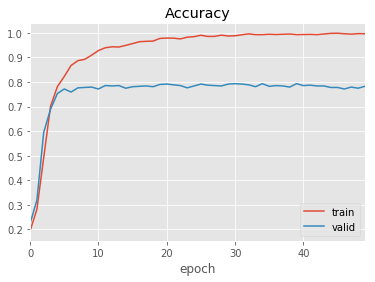

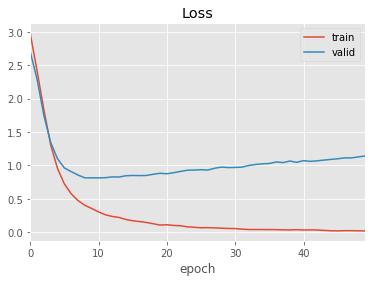

In [9]:
model = get_garbage_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
hist = model.fit(train_x ,train_y, epochs=50, validation_data=(valid_x, valid_y), verbose=0)
record(hist)